In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_medium_aug_k_2_focal_patch64'
data_conf['patches'] = {
    'train': (64, 64, 1),
    'val': (64, 64, 1),
    'test': (64, 64, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_medium_aug_k_2_focal_patch64',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (

In [9]:
model_config['encoder_name'] = 'resnet101'
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet101',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 1e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 1e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'medium'
aug_config['k'] = 2
aug_config['original_height'] = 64
aug_config['original_width'] = 64
aug_config

{'aug_type': 'medium', 'original_height': 64, 'original_width': 64, 'k': 2}

In [12]:
loss_config =[
    {
        'loss': 'Focal', 
        'weight': 1, 
        'params': {
            'alpha': 0.5,
            'gamma': 2
        }
    },
    {
        'loss': 'Dice',
        'weight': 1, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'Focal', 'weight': 1, 'params': {'alpha': 0.5, 'gamma': 2}},
 {'loss': 'Dice',
  'weight': 1,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 256
dataloaders_conf['val']['batch_size'] = 256
dataloaders_conf['test']['batch_size'] = 256
dataloaders_conf

{'train': {'batch_size': 256, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 256, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 256, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 675.05it/s]
100%|██████████| 720/720 [00:07<00:00, 92.16it/s] 
33120it [00:00, 243294.98it/s]
31680it [00:00, 158259.03it/s]
700it [00:00, 832.66it/s]
100%|██████████| 700/700 [00:06<00:00, 100.09it/s]
27830it [00:00, 145458.25it/s]
26620it [00:00, 250227.75it/s]
710it [00:00, 868.26it/s]
100%|██████████| 710/710 [00:07<00:00, 96.35it/s] 
31680it [00:00, 141727.42it/s]
30240it [00:00, 128306.40it/s]
720it [00:00, 838.60it/s]
100%|██████████| 720/720 [00:07<00:00, 94.86it/s] 
33120it [00:00, 250814.01it/s]
720it [00:00, 812.37it/s]
100%|██████████| 720/720 [00:07<00:00, 93.37it/s] 
103680it [00:00, 172026.57it/s]
700it [00:01, 674.41it/s]
100%|██████████| 700/700 [00:06<00:00, 100.15it/s]
84700it [00:00, 214528.67it/s]
509it [00:00, 1127.15it/s]
100%|██████████| 509/509 [00:02<00:00, 191.90it/s]
32576it [00:00, 91198.05it/s]
700it [00:00, 832.09it/s]
100%|██████████| 700/700 [00:07<00:00, 99.67it/s] 
84700it [00:00, 227711.39it/s]
700it [00:00, 779.71it/s]
100%|██████████|

In [15]:
len(data_train), len(data_val), len(data_test)

(92630, 88540, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.12687


100%|██████████| 346/346 [00:42<00:00,  8.17it/s]


Mean val loss: 0.031314


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.030677


100%|██████████| 346/346 [00:41<00:00,  8.28it/s]


Mean val loss: 0.017696


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.025314


100%|██████████| 346/346 [00:41<00:00,  8.30it/s]


Mean val loss: 0.014277


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023818


100%|██████████| 346/346 [00:41<00:00,  8.26it/s]


Mean val loss: 0.012112


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.023127


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.014007
EarlyStopping counter: 1 out of 15
Epoch 5...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022663


100%|██████████| 346/346 [00:42<00:00,  8.11it/s]


Mean val loss: 0.010408


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022369


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011118
EarlyStopping counter: 1 out of 15
Epoch 7...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022122


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.019054
EarlyStopping counter: 2 out of 15
Epoch 8...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.022202


100%|██████████| 346/346 [00:41<00:00,  8.33it/s]


Mean val loss: 0.010228


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021837


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010362
EarlyStopping counter: 1 out of 15
Epoch 10...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021699


100%|██████████| 346/346 [00:41<00:00,  8.27it/s]


Mean val loss: 0.0088194


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 11...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021588


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0095792
EarlyStopping counter: 1 out of 15
Epoch 12...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021554


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010434
EarlyStopping counter: 2 out of 15
Epoch 13...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021388


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.018317
EarlyStopping counter: 3 out of 15
Epoch 14...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021398


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010461
EarlyStopping counter: 4 out of 15
Epoch 15...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021341


100%|██████████| 346/346 [00:42<00:00,  8.20it/s]


Mean val loss: 0.0085858


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 16...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.021015


100%|██████████| 346/346 [00:41<00:00,  8.26it/s]


Mean val loss: 0.0084035


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 17...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020839


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0087161
EarlyStopping counter: 1 out of 15
Epoch 18...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020703


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012749
EarlyStopping counter: 2 out of 15
Epoch 19...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020712


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013771
EarlyStopping counter: 3 out of 15
Epoch 20...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020572


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0086636
EarlyStopping counter: 4 out of 15
Epoch 21...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020496


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013732
EarlyStopping counter: 5 out of 15
Epoch 22...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02042


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0089663
EarlyStopping counter: 6 out of 15
Epoch 23...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020328


100%|██████████| 346/346 [00:41<00:00,  8.24it/s]


Mean val loss: 0.008077


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 24...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020333


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010865
EarlyStopping counter: 1 out of 15
Epoch 25...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020315


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0083622
EarlyStopping counter: 2 out of 15
Epoch 26...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020225


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0080943
EarlyStopping counter: 3 out of 15
Epoch 27...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020195


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0083578
EarlyStopping counter: 4 out of 15
Epoch 28...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020269


100%|██████████| 346/346 [00:42<00:00,  8.23it/s]


Mean val loss: 0.0079322


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 29...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.02016


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.008651
EarlyStopping counter: 1 out of 15
Epoch 30...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020054


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0089507
EarlyStopping counter: 2 out of 15
Epoch 31...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020008


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.011435
EarlyStopping counter: 3 out of 15
Epoch 32...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.020032


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0079735
EarlyStopping counter: 4 out of 15
Epoch 33...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019991


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0080135
EarlyStopping counter: 5 out of 15
Epoch 34...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019962


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0086588
EarlyStopping counter: 6 out of 15
Epoch 35...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019936


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0097037
EarlyStopping counter: 7 out of 15
Epoch 36...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019971


100%|██████████| 346/346 [00:41<00:00,  8.26it/s]


Mean val loss: 0.0078066


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 37...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019906


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.013538
EarlyStopping counter: 1 out of 15
Epoch 38...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019864


100%|██████████| 346/346 [00:42<00:00,  8.22it/s]


Mean val loss: 0.0078034


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 39...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019932


100%|██████████| 346/346 [00:42<00:00,  8.21it/s]


Mean val loss: 0.0077304


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 40...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01988


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.016647
EarlyStopping counter: 1 out of 15
Epoch 41...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019833


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0078399
EarlyStopping counter: 2 out of 15
Epoch 42...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019832


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0077748
EarlyStopping counter: 3 out of 15
Epoch 43...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019833


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012753
EarlyStopping counter: 4 out of 15
Epoch 44...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019807


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0077325
EarlyStopping counter: 5 out of 15
Epoch 45...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019734


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0094418
EarlyStopping counter: 6 out of 15
Epoch 46...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019682


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0083161
EarlyStopping counter: 7 out of 15
Epoch 47...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01978


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0084709
EarlyStopping counter: 8 out of 15
Epoch 48...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019787


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0082178
EarlyStopping counter: 9 out of 15
Epoch 49...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019734


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.014045
EarlyStopping counter: 10 out of 15
Epoch 50...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01994


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0089347
EarlyStopping counter: 11 out of 15
Epoch 51...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019748


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.015092
EarlyStopping counter: 12 out of 15
Epoch 52...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019653


100%|██████████| 346/346 [00:42<00:00,  8.11it/s]


Mean val loss: 0.0077188


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 53...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019723


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.097334
EarlyStopping counter: 1 out of 15
Epoch 54...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019995


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.007973
EarlyStopping counter: 2 out of 15
Epoch 55...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019746


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0081936
EarlyStopping counter: 3 out of 15
Epoch 56...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019749


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.00806
EarlyStopping counter: 4 out of 15
Epoch 57...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019686


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.008255
EarlyStopping counter: 5 out of 15
Epoch 58...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019662
Epoch    58: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0081635
EarlyStopping counter: 6 out of 15
Epoch 59...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019472


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.010168
EarlyStopping counter: 7 out of 15
Epoch 60...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019401


100%|██████████| 346/346 [00:43<00:00,  8.05it/s]


Mean val loss: 0.0076594


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 61...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019456


100%|██████████| 346/346 [00:42<00:00,  8.10it/s]


Mean val loss: 0.007569


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 62...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01948


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.012051
EarlyStopping counter: 1 out of 15
Epoch 63...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019401


100%|██████████| 346/346 [00:42<00:00,  8.22it/s]


Mean val loss: 0.0075597


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 64...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019486


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0075645
EarlyStopping counter: 1 out of 15
Epoch 65...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019458


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.007561
EarlyStopping counter: 2 out of 15
Epoch 66...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019387


100%|██████████| 346/346 [00:41<00:00,  8.25it/s]


Mean val loss: 0.0074889


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 67...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019416


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0076028
EarlyStopping counter: 1 out of 15
Epoch 68...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019386


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0075272
EarlyStopping counter: 2 out of 15
Epoch 69...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019458


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0076655
EarlyStopping counter: 3 out of 15
Epoch 70...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019389


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0077206
EarlyStopping counter: 4 out of 15
Epoch 71...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019327


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019369


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0075145
EarlyStopping counter: 6 out of 15
Epoch 73...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019382


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074965
EarlyStopping counter: 7 out of 15
Epoch 74...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01939


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.007776
EarlyStopping counter: 8 out of 15
Epoch 75...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019382


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0075759
EarlyStopping counter: 9 out of 15
Epoch 76...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019382


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0075669
EarlyStopping counter: 10 out of 15
Epoch 77...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019376
Epoch    77: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0076078
EarlyStopping counter: 11 out of 15
Epoch 78...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019338


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0097296
EarlyStopping counter: 12 out of 15
Epoch 79...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019299


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0075089
EarlyStopping counter: 13 out of 15
Epoch 80...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019323


100%|██████████| 346/346 [00:41<00:00,  8.30it/s]


Mean val loss: 0.0074569


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 81...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01931


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0083481
EarlyStopping counter: 1 out of 15
Epoch 82...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019301


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0075139
EarlyStopping counter: 2 out of 15
Epoch 83...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019324


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0075
EarlyStopping counter: 3 out of 15
Epoch 84...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019334


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0076745
EarlyStopping counter: 4 out of 15
Epoch 85...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019285


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.007548
EarlyStopping counter: 5 out of 15
Epoch 86...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019234


100%|██████████| 346/346 [00:42<00:00,  8.13it/s]


Mean val loss: 0.0074338


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 87...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019288


100%|██████████| 346/346 [00:41<00:00,  8.25it/s]


Mean val loss: 0.0074298


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 88...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019317


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074347
EarlyStopping counter: 1 out of 15
Epoch 89...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01921


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074356
EarlyStopping counter: 2 out of 15
Epoch 90...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.0193


100%|██████████| 346/346 [00:42<00:00,  8.12it/s]


Mean val loss: 0.0074132


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 91...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019276


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074614
EarlyStopping counter: 1 out of 15
Epoch 92...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019303


100%|██████████| 346/346 [00:43<00:00,  8.03it/s]


Mean val loss: 0.0074134


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 93...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019239


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074232
EarlyStopping counter: 1 out of 15
Epoch 94...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019275


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074356
EarlyStopping counter: 2 out of 15
Epoch 95...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019346
Epoch    95: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074461
EarlyStopping counter: 3 out of 15
Epoch 96...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019248


100%|██████████| 346/346 [00:41<00:00,  8.33it/s]


Mean val loss: 0.0074079


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 97...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019212


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.007432
EarlyStopping counter: 1 out of 15
Epoch 98...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019236


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074103
EarlyStopping counter: 2 out of 15
Epoch 99...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019209


100%|██████████| 346/346 [00:42<00:00,  8.19it/s]


Mean val loss: 0.0074038


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 100...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019229


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074136
EarlyStopping counter: 1 out of 15
Epoch 101...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019208
Epoch   101: reducing learning rate of group 0 to 6.2500e-05.


100%|██████████| 346/346 [00:42<00:00,  8.11it/s]


Mean val loss: 0.007395


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 102...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019205


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074022
EarlyStopping counter: 1 out of 15
Epoch 103...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019193


100%|██████████| 346/346 [00:42<00:00,  8.17it/s]


Mean val loss: 0.0073877


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 104...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01922


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073891
EarlyStopping counter: 1 out of 15
Epoch 105...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019177


100%|██████████| 346/346 [00:42<00:00,  8.12it/s]


Mean val loss: 0.0073855


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 106...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019231


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073957
EarlyStopping counter: 1 out of 15
Epoch 107...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019247


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073865
EarlyStopping counter: 2 out of 15
Epoch 108...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019252


100%|██████████| 346/346 [00:41<00:00,  8.25it/s]


Mean val loss: 0.0073836


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 109...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019125


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074227
EarlyStopping counter: 1 out of 15
Epoch 110...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01922


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074172
EarlyStopping counter: 2 out of 15
Epoch 111...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019256


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074322
EarlyStopping counter: 3 out of 15
Epoch 112...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019229


100%|██████████| 346/346 [00:42<00:00,  8.22it/s]


Mean val loss: 0.0073839


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 113...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019169


100%|██████████| 346/346 [00:42<00:00,  8.21it/s]


Mean val loss: 0.0073824


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 114...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019203


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0074051
EarlyStopping counter: 1 out of 15
Epoch 115...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019166
Epoch   115: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073902
EarlyStopping counter: 2 out of 15
Epoch 116...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019174


100%|██████████| 346/346 [00:42<00:00,  8.23it/s]


Mean val loss: 0.0073817


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 117...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019172


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073858
EarlyStopping counter: 1 out of 15
Epoch 118...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019264


100%|██████████| 346/346 [00:42<00:00,  8.08it/s]


Mean val loss: 0.0073785


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 119...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019213


100%|██████████| 346/346 [00:41<00:00,  8.27it/s]


Mean val loss: 0.0073775


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 120...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019184


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073934
EarlyStopping counter: 1 out of 15
Epoch 121...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019123
Epoch   121: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073815
EarlyStopping counter: 2 out of 15
Epoch 122...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019159


100%|██████████| 346/346 [00:42<00:00,  8.18it/s]


Mean val loss: 0.007377


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 123...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019209


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073783
EarlyStopping counter: 1 out of 15
Epoch 124...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019159


100%|██████████| 346/346 [00:42<00:00,  8.20it/s]


Mean val loss: 0.0073778


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 125...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019257


100%|██████████| 346/346 [00:43<00:00,  8.02it/s]


Mean val loss: 0.0073785


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 126...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019212


100%|██████████| 346/346 [00:41<00:00,  8.24it/s]


Mean val loss: 0.007377


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 127...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019188
Epoch   127: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073858
EarlyStopping counter: 1 out of 15
Epoch 128...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019218


100%|██████████| 346/346 [00:42<00:00,  8.19it/s]


Mean val loss: 0.0073777


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 129...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019098


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073829
EarlyStopping counter: 1 out of 15
Epoch 130...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01913


100%|██████████| 346/346 [00:41<00:00,  8.27it/s]


Mean val loss: 0.0073781


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 131...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019215


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073827
EarlyStopping counter: 1 out of 15
Epoch 132...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019225


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073898
EarlyStopping counter: 2 out of 15
Epoch 133...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019128


100%|██████████| 346/346 [00:41<00:00,  8.32it/s]


Mean val loss: 0.0073757


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 134...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019161


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073788
EarlyStopping counter: 1 out of 15
Epoch 135...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019113
Epoch   135: reducing learning rate of group 0 to 3.9063e-06.


100%|██████████| 346/346 [00:41<00:00,  8.26it/s]


Mean val loss: 0.0073758


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 136...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019186


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073812
EarlyStopping counter: 1 out of 15
Epoch 137...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019185


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073823
EarlyStopping counter: 2 out of 15
Epoch 138...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019244


100%|██████████| 346/346 [00:42<00:00,  8.22it/s]


Mean val loss: 0.0073723


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 139...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019192


100%|██████████| 346/346 [00:41<00:00,  8.28it/s]


Mean val loss: 0.0073722


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 140...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019133


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.007376
EarlyStopping counter: 1 out of 15
Epoch 141...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019165
Epoch   141: reducing learning rate of group 0 to 1.9531e-06.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073797
EarlyStopping counter: 2 out of 15
Epoch 142...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019204


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073765
EarlyStopping counter: 3 out of 15
Epoch 143...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019154


100%|██████████| 346/346 [00:42<00:00,  8.20it/s]


Mean val loss: 0.0073731


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 144...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019204


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073752
EarlyStopping counter: 1 out of 15
Epoch 145...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019252


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.007376
EarlyStopping counter: 2 out of 15
Epoch 146...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019186


100%|██████████| 346/346 [00:42<00:00,  8.17it/s]


Mean val loss: 0.0073738


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 147...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019169
Epoch   147: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073803
EarlyStopping counter: 1 out of 15
Epoch 148...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019195


100%|██████████| 346/346 [00:41<00:00,  8.29it/s]


Mean val loss: 0.0073737


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 149...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019105


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073776
EarlyStopping counter: 1 out of 15
Epoch 150...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019212


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073773
EarlyStopping counter: 2 out of 15
Epoch 151...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019181


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073927
EarlyStopping counter: 3 out of 15
Epoch 152...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019132


100%|██████████| 346/346 [00:42<00:00,  8.16it/s]


Mean val loss: 0.0073747


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 153...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019146


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073838
EarlyStopping counter: 1 out of 15
Epoch 154...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019129


100%|██████████| 346/346 [00:42<00:00,  8.17it/s]


Mean val loss: 0.007375


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 155...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019208


100%|██████████| 346/346 [00:42<00:00,  8.09it/s]


Mean val loss: 0.007375


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 156...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019184


100%|██████████| 346/346 [00:42<00:00,  8.16it/s]


Mean val loss: 0.0073742


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 157...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019129


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073794
EarlyStopping counter: 1 out of 15
Epoch 158...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019171


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073797
EarlyStopping counter: 2 out of 15
Epoch 159...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019119


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073811
EarlyStopping counter: 3 out of 15
Epoch 160...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019206


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073838
EarlyStopping counter: 4 out of 15
Epoch 161...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.01918


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073807
EarlyStopping counter: 5 out of 15
Epoch 162...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019194


100%|██████████| 346/346 [00:41<00:00,  8.32it/s]


Mean val loss: 0.0073712


  0%|          | 0/362 [00:00<?, ?it/s]

Epoch 163...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019181


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073758
EarlyStopping counter: 1 out of 15
Epoch 164...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019148


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073784
EarlyStopping counter: 2 out of 15
Epoch 165...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019113


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073787
EarlyStopping counter: 3 out of 15
Epoch 166...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019162


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073865
EarlyStopping counter: 4 out of 15
Epoch 167...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019259


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073773
EarlyStopping counter: 5 out of 15
Epoch 168...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019191


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073765
EarlyStopping counter: 6 out of 15
Epoch 169...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019077


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073742
EarlyStopping counter: 7 out of 15
Epoch 170...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019169


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073738
EarlyStopping counter: 8 out of 15
Epoch 171...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019221


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.007378
EarlyStopping counter: 9 out of 15
Epoch 172...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019202


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073771
EarlyStopping counter: 10 out of 15
Epoch 173...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019159


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073732
EarlyStopping counter: 11 out of 15
Epoch 174...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019202


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073755
EarlyStopping counter: 12 out of 15
Epoch 175...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019164


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073858
EarlyStopping counter: 13 out of 15
Epoch 176...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019132


  0%|          | 0/362 [00:00<?, ?it/s]

Mean val loss: 0.0073842
EarlyStopping counter: 14 out of 15
Epoch 177...


  0%|          | 0/346 [00:00<?, ?it/s]

Mean train loss: 0.019151


  0%|          | 0/130 [00:00<?, ?it/s]

Mean val loss: 0.0073773
EarlyStopping counter: 15 out of 15


100%|██████████| 331/331 [07:54<00:00,  1.43s/it]


## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

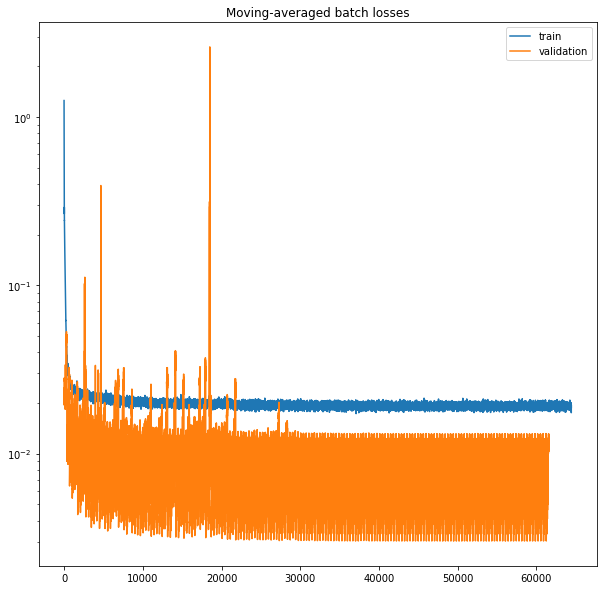

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

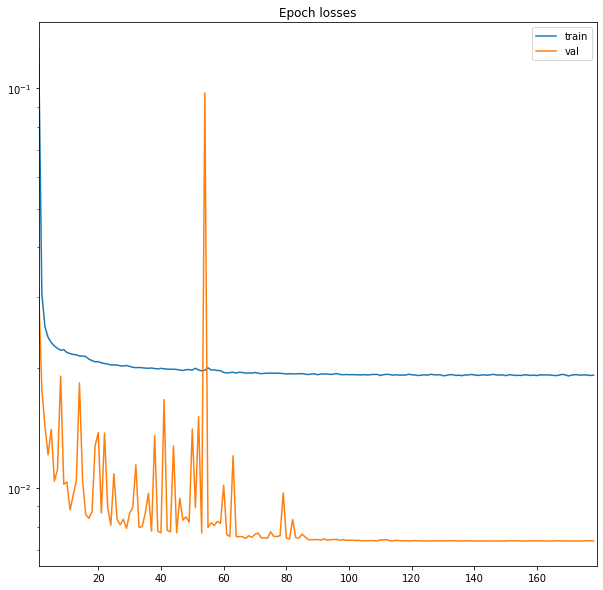

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996663,0.978657,0.974621,0.976635,0.998366,0.954337,carb96558,basic
1,0.988961,0.922154,0.985831,0.952930,0.994702,0.910092,carb71,basic
2,0.979818,0.957811,0.861651,0.907190,0.978338,0.830144,carbRNF,basic
3,0.992054,0.985058,0.923657,0.953370,0.994277,0.910895,SPE_carb10_58_box3,basic
4,0.989784,0.981490,0.914545,0.946836,0.992777,0.899039,SoilAh-1,basic
5,0.996219,0.970872,0.965540,0.968199,0.996807,0.938358,SoilB-2,basic
6,0.989370,0.995986,0.924279,0.958793,0.996929,0.920848,TeTree_subset1,basic
7,0.993505,0.994491,0.943702,0.968431,0.997906,0.938794,TiTree_subset2,basic
8,0.992246,0.971127,0.966807,0.968962,0.997078,0.939793,Urna_22,basic
9,0.990140,0.973508,0.968177,0.970835,0.997695,0.943323,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91606
Std    IOU: 0.034883
Min    IOU: 0.83014
Median IOU: 0.92085


## Check loss to loss ratio

In [34]:
criterion.losses

(WeightedLoss(
   (loss): FocalLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [35]:
from stack_segmentation.training import make_joint_loss

In [36]:
import torch

In [37]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [38]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [39]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0021
Mean 1 loss: 0.0023
Mean of ratios: 0.9235
Ratio of means: 0.9180
